In [1]:
from models.clip_detector.detector import CLIPDetector
import torch
from PIL import Image
from io import BytesIO
from data import RefCocoBatch, RefCocoConfig, RefCocoDataset
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
cfg = RefCocoConfig({
    "path": "../refcocog"
})

train_dataset = RefCocoDataset(config = cfg, phase = "train")
test_dataset = RefCocoDataset(config = cfg, phase = "test")

In [3]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=RefCocoDataset.batchify)

In [4]:
import spacy

"""
NER = spacy.load("en_core_web_sm")

for batch in tqdm(train_dataloader):
    for s in batch.sentences:
        text = NER(s[0])
        print(s[0])
        print(text.ents)    
    break
"""

'\nNER = spacy.load("en_core_web_sm")\n\nfor batch in tqdm(train_dataloader):\n    for s in batch.sentences:\n        text = NER(s[0])\n        print(s[0])\n        print(text.ents)    \n    break\n'

### Model

In [5]:
import clip
import torch.optim as optim

device = "cuda"
model = CLIPDetector(device=device) 
#model, preprocessor = clip.load("ViT-B/32", device=device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

In [6]:
def contrastive_loss(logits, tau = 1):
        """ 
            Very simple one-positive contrastive loss
            similarity:     a pre-computed distance matrix
            https://jamesmccaffrey.wordpress.com/2022/03/04/contrastive-loss-function-in-pytorch/
        """
        return torch.sum(
            torch.stack(
                [-torch.log(torch.exp(row[i]/tau) / (torch.sum(torch.exp(row / tau)) - torch.exp(row[i] / tau))) for i, row in enumerate(logits)]
            )
        )

In [7]:
loss_fn = torch.nn.HuberLoss()
# loss_fn = contrastive_loss

In [8]:
import numpy as np 

# per epoch: 11 mins on a single RTX 3070 Laptop
epochs = 1
overall_loss = []

for epoch in range(epochs):

    epoch_loss = []
    for batch in tqdm(train_dataloader):
    
        optimizer.zero_grad()
        
        # logits_img, logits_txt = model(batch.images, batch.sentences)
        # loss = loss_fn(logits_img)
        
        bboxes = model(batch.images, batch.sentences)
        loss = loss_fn(bboxes, batch.bboxes.to(device))

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.detach().cpu().numpy())
        overall_loss.append(loss.detach().cpu().numpy())
        
    print(f"Epoch loss: \t{np.mean(epoch_loss)}\n")

100%|██████████| 2640/2640 [15:59<00:00,  2.75it/s]


Epoch loss: 	165.0358123779297



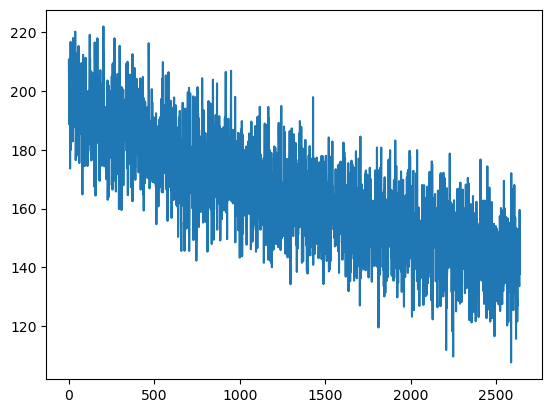

In [9]:
import matplotlib.pyplot as plt

plt.plot(overall_loss)


### Evaluating

In [ ]:
batch_size = 16
test_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=RefCocoDataset.batchify)

In [ ]:
for batch in test_dataloader:
    print(model.inference(batch.images, batch.sentences))

    break